In [2]:
#librerrias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyodbc

import seaborn as sns

 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale


from sklearn.metrics import silhouette_score, davies_bouldin_score
from datetime import datetime
from sklearn.cluster import KMeans


## 1. Seleccion

In [3]:
# Conexión a base de datos
# Credenciales  BD_STAGE
conn = pyodbc.connect(DRIVER = '{ODBC Driver 17 for SQL Server}',
                      SERVER = 'med000008646',
                      DATABASE = 'BD_STAGE',
                      UID = 'usconsulta',
                      PWD = 'consulta')

# Credenciales  db_sifods
conn1 = pyodbc.connect(DRIVER = '{ODBC Driver 17 for SQL Server}',
                      SERVER = 'med000008646',
                      DATABASE = 'db_sifods',
                      UID = 'usconsulta',
                      PWD = 'consulta')


In [4]:
# Consultas sql
q1 = """SELECT a.ID,a.ID_OFERTA_FORMATIVA,a.ID_GRUPO,a.ID_CURSO,a.ID_PARTICIPANTE,a.CURID,a.USERID,a.NOTA,a.NOTA_MAXIMA,a.CONDICION,
		b.USUARIO_DOCUMENTO
FROM [st].[SI_acfm.transaccional.oferta_formativa_curso_participante] a
INNER JOIN [st].[SI_acfm.transaccional.oferta_formativa_participante] b ON a.ID_PARTICIPANTE=b.ID_PARTICIPANTE
WHERE CURID=623 AND CUMPLIMIENTO_ACTIVIDAD = 'COMPLETARON' """

df = pd.read_sql_query(q1 , conn)

q2 = """
        SELECT DNI
            ,NIVEL_NEXUS
            ,DESCRIPCION_TIPO_TRABAJADOR
            ,ESCALA_DIFODS
            ,SITUACION_LABORAL_DIFODS
            ,EDAD
            ,SEXO
            ,DAREACENSO
        FROM [dct].[maestro.nexus_escale]
        """
doc_nexus = pd.read_sql_query(q2,conn1)


# Cerrar la conexión a la base de datos db_sifods
conn.close()
conn1.close()

C:\Users\DIFODS103\AppData\Local\Temp\ipykernel_10476\3572683686.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(q1 , conn)
C:\Users\DIFODS103\AppData\Local\Temp\ipykernel_10476\3572683686.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  doc_nexus = pd.read_sql_query(q2,conn1)


**Oferta formativa curso participante**

In [5]:
df.head(3)

,ID,ID_OFERTA_FORMATIVA,ID_GRUPO,ID_CURSO,ID_PARTICIPANTE,CURID,USERID,NOTA,NOTA_MAXIMA,CONDICION,USUARIO_DOCUMENTO
0,2825510,236,880,256,2345944,623,204810,16.0,20.0,APROBADO,00234413
1,3663662,236,880,256,2345944,623,204810,16.0,20.0,APROBADO,00234413
2,4170119,236,880,256,2345944,623,204810,16.0,20.0,APROBADO,00234413


In [6]:
doc_nexus.head(3)

,DNI,NIVEL_NEXUS,DESCRIPCION_TIPO_TRABAJADOR,ESCALA_DIFODS,SITUACION_LABORAL_DIFODS,EDAD,SEXO,DAREACENSO
0,00002991,Básica Especial-Inicial,DOCENTE,2,NOMBRADO,57.0,FEMENINO,Urbana
1,00002408,Secundaria,DOCENTE,2,NOMBRADO,57.0,MASCULINO,Urbana
2,00004612,Secundaria,DOCENTE,3,NOMBRADO,56.0,MASCULINO,Urbana


## 2. Preprocesamiento

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162634 entries, 0 to 162633
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   162634 non-null  int64  
 1   ID_OFERTA_FORMATIVA  162634 non-null  int64  
 2   ID_GRUPO             162634 non-null  int64  
 3   ID_CURSO             162634 non-null  int64  
 4   ID_PARTICIPANTE      162634 non-null  int64  
 5   CURID                162634 non-null  int64  
 6   USERID               162634 non-null  int64  
 7   NOTA                 160526 non-null  float64
 8   NOTA_MAXIMA          160526 non-null  float64
 9   CONDICION            162634 non-null  object 
 10  USUARIO_DOCUMENTO    162634 non-null  object 
dtypes: float64(2), int64(7), object(2)
memory usage: 13.6+ MB


In [121]:
df.isnull().sum()

ID                        0
ID_OFERTA_FORMATIVA       0
ID_GRUPO                  0
ID_CURSO                  0
ID_PARTICIPANTE           0
CURID                     0
USERID                    0
NOTA                   2108
NOTA_MAXIMA            2108
CONDICION                 0
USUARIO_DOCUMENTO         0
dtype: int64

In [8]:
#Eliminar los registros con valores null
df.dropna(inplace=True)

In [9]:
# Evidencia de valores duplicados
dup_df = df.groupby(['ID_CURSO','ID_GRUPO','ID_PARTICIPANTE'])['ID_PARTICIPANTE'].count().sort_values(ascending=False).to_frame('CONTEO').reset_index()
dup_df[dup_df['CONTEO']>1].sort_values('ID_CURSO')

,ID_CURSO,ID_GRUPO,ID_PARTICIPANTE,CONTEO
1940,244,876,2333733,35
2330,244,876,2341638,34
2335,244,876,2339813,34
2337,244,876,2338048,34
2340,244,876,2338246,34
...,...,...,...,...
5119,433,951,2390794,13
3836,433,951,2374809,23
3840,433,951,2377227,23
4638,433,951,2387303,18


In [10]:
# Numero de duplicados por id_participante
df= df.drop_duplicates(['ID_CURSO','ID_GRUPO','ID_PARTICIPANTE'],keep='last')

In [11]:
df

,ID,ID_OFERTA_FORMATIVA,ID_GRUPO,ID_CURSO,ID_PARTICIPANTE,CURID,USERID,NOTA,NOTA_MAXIMA,CONDICION,USUARIO_DOCUMENTO
1638,2825838,237,882,262,2325916,623,237891,20.0,20.0,APROBADO,03503812
2930,2329090,237,882,262,2335608,623,273558,18.0,20.0,APROBADO,27044210
3560,2825163,238,885,271,2326088,623,213275,20.0,20.0,APROBADO,40287462
3624,244866,238,887,277,2359857,623,445203,20.0,20.0,APROBADO,47193555
3631,223599,237,884,268,2359879,623,566648,20.0,20.0,APROBADO,80202753
...,...,...,...,...,...,...,...,...,...,...,...
162552,2462474,240,929,370,2366619,623,304727,20.0,20.0,APROBADO,26652325
162564,4305076,242,951,433,2383236,623,590414,18.0,20.0,APROBADO,01158716
162583,4365132,239,945,415,2383379,623,607523,20.0,20.0,APROBADO,71438513
162605,3357016,239,945,415,2383524,623,560128,14.0,20.0,APROBADO,47669229


**Union de tablas**

In [12]:
df_tbl = df.merge(doc_nexus, how='left',left_on='USUARIO_DOCUMENTO',right_on='DNI')
df_tbl.head(5)

,ID,ID_OFERTA_FORMATIVA,ID_GRUPO,ID_CURSO,ID_PARTICIPANTE,CURID,USERID,NOTA,NOTA_MAXIMA,CONDICION,USUARIO_DOCUMENTO,DNI,NIVEL_NEXUS,DESCRIPCION_TIPO_TRABAJADOR,ESCALA_DIFODS,SITUACION_LABORAL_DIFODS,EDAD,SEXO,DAREACENSO
0,2825838,237,882,262,2325916,623,237891,20.0,20.0,APROBADO,03503812,03503812,Secundaria,DOCENTE,2,NOMBRADO,53.0,FEMENINO,Urbana
1,2329090,237,882,262,2335608,623,273558,18.0,20.0,APROBADO,27044210,27044210,Secundaria,DOCENTE,5,NOMBRADO,61.0,MASCULINO,Urbana
2,2825163,238,885,271,2326088,623,213275,20.0,20.0,APROBADO,40287462,40287462,Secundaria,DOCENTE,2,NOMBRADO,42.0,FEMENINO,Urbana
3,244866,238,887,277,2359857,623,445203,20.0,20.0,APROBADO,47193555,47193555,Primaria,DOCENTE,None,CONTRATADO,31.0,MASCULINO,Urbana
4,223599,237,884,268,2359879,623,566648,20.0,20.0,APROBADO,80202753,80202753,Secundaria,DOCENTE,1,CONTRATADO,44.0,MASCULINO,Rural


In [134]:
df_tbl.isnull().sum()

ID                                0
ID_OFERTA_FORMATIVA               0
ID_GRUPO                          0
ID_CURSO                          0
ID_PARTICIPANTE                   0
CURID                             0
USERID                            0
NOTA                              0
NOTA_MAXIMA                       0
CONDICION                         0
USUARIO_DOCUMENTO                 0
DNI                            1326
NIVEL_NEXUS                    1326
DESCRIPCION_TIPO_TRABAJADOR    1326
ESCALA_DIFODS                  1463
SITUACION_LABORAL_DIFODS       1326
EDAD                           1326
SEXO                           1326
DAREACENSO                     1326
dtype: int64

In [14]:
df_tbl_f1 = df_tbl.dropna()

In [15]:
df_tbl_f1.head(4)

,ID,ID_OFERTA_FORMATIVA,ID_GRUPO,ID_CURSO,ID_PARTICIPANTE,CURID,USERID,NOTA,NOTA_MAXIMA,CONDICION,USUARIO_DOCUMENTO,DNI,NIVEL_NEXUS,DESCRIPCION_TIPO_TRABAJADOR,ESCALA_DIFODS,SITUACION_LABORAL_DIFODS,EDAD,SEXO,DAREACENSO
0,2825838,237,882,262,2325916,623,237891,20.0,20.0,APROBADO,03503812,03503812,Secundaria,DOCENTE,2,NOMBRADO,53.0,FEMENINO,Urbana
1,2329090,237,882,262,2335608,623,273558,18.0,20.0,APROBADO,27044210,27044210,Secundaria,DOCENTE,5,NOMBRADO,61.0,MASCULINO,Urbana
2,2825163,238,885,271,2326088,623,213275,20.0,20.0,APROBADO,40287462,40287462,Secundaria,DOCENTE,2,NOMBRADO,42.0,FEMENINO,Urbana
4,223599,237,884,268,2359879,623,566648,20.0,20.0,APROBADO,80202753,80202753,Secundaria,DOCENTE,1,CONTRATADO,44.0,MASCULINO,Rural


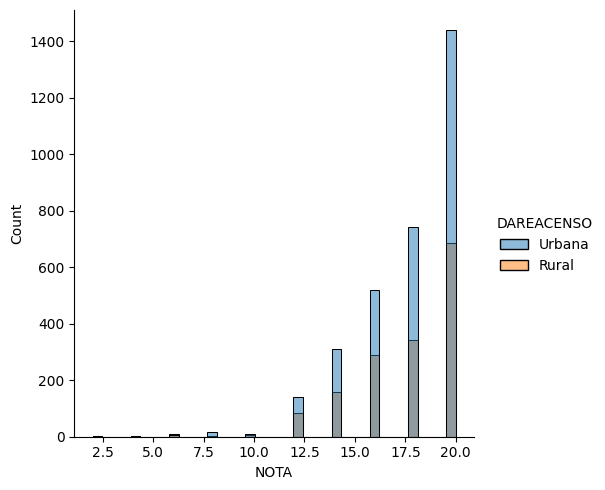

In [16]:
sns.displot(data=df_tbl_f1, x='NOTA',hue='DAREACENSO')
plt.show()

In [160]:
df_tbl_f1[df_tbl_f1['CONDICION']=='NO APROBADO']

,ID,ID_OFERTA_FORMATIVA,ID_GRUPO,ID_CURSO,ID_PARTICIPANTE,CURID,USERID,NOTA,NOTA_MAXIMA,CONDICION,USUARIO_DOCUMENTO,DNI,NIVEL_NEXUS,DESCRIPCION_TIPO_TRABAJADOR,ESCALA_DIFODS,SITUACION_LABORAL_DIFODS,EDAD,SEXO,DAREACENSO
23,227038,235,876,244,2340080,623,598397,8.0,20.0,NO APROBADO,29334391,29334391,Inicial - Jardín,DOCENTE,1,CONTRATADO,60.0,FEMENINO,Urbana
594,4181699,236,879,253,2340246,623,337224,8.0,20.0,NO APROBADO,09484377,09484377,Primaria,DOCENTE,6,NOMBRADO,52.0,FEMENINO,Urbana
697,3659874,237,882,262,2340758,623,584733,10.0,20.0,NO APROBADO,28995464,28995464,Secundaria,DOCENTE,1,CONTRATADO,49.0,FEMENINO,Rural
704,3466272,235,876,244,2340829,623,553894,10.0,20.0,NO APROBADO,70375948,70375948,Inicial - Jardín,DOCENTE,1,CONTRATADO,28.0,FEMENINO,Urbana
1000,4184678,239,927,364,2367403,623,497995,8.0,20.0,NO APROBADO,40282337,40282337,Inicial - Cuna-jardín,DOCENTE,1,CONTRATADO,43.0,FEMENINO,Urbana
1001,4185328,235,919,340,2367405,623,497995,8.0,20.0,NO APROBADO,40282337,40282337,Inicial - Cuna-jardín,DOCENTE,1,CONTRATADO,43.0,FEMENINO,Urbana
1062,4177042,240,891,289,2341828,623,276754,8.0,20.0,NO APROBADO,08831511,08831511,Primaria,DOCENTE,4,NOMBRADO,58.0,FEMENINO,Urbana
1204,1921230,241,894,298,2335683,623,461728,10.0,20.0,NO APROBADO,20064600,20064600,Secundaria,DOCENTE,1,CONTRATADO,52.0,MASCULINO,Urbana
1515,3000591,238,885,271,2336173,623,472814,6.0,20.0,NO APROBADO,06880751,06880751,Secundaria,DOCENTE,1,CONTRATADO,56.0,FEMENINO,Urbana
1628,4008615,236,879,253,2336851,623,826,10.0,20.0,NO APROBADO,29571995,29571995,Primaria,DOCENTE,3,NOMBRADO,54.0,FEMENINO,Urbana


In [17]:
print(df_tbl_f1['CONDICION'].unique())
print(df_tbl_f1['NIVEL_NEXUS'].unique())
print(df_tbl_f1['DESCRIPCION_TIPO_TRABAJADOR'].unique())
print(df_tbl_f1['ESCALA_DIFODS'].unique())
print(df_tbl_f1['SITUACION_LABORAL_DIFODS'].unique())
print(df_tbl_f1['SEXO'].unique())
print(df_tbl_f1['DAREACENSO'].unique())

['APROBADO' 'NO APROBADO']
['Secundaria' 'Primaria' 'Inicial - Jardín' 'Básica Alternativa-Avanzado'
 'Básica Alternativa-Inicial e I' 'Inicial - Cuna-jardín'
 'Básica Especial-Primaria']
['DOCENTE']
['2' '5' '1' '3' '4' '6' '7']
['NOMBRADO' 'CONTRATADO']
['FEMENINO' 'MASCULINO']
['Urbana' 'Rural']


In [24]:
#Reclasificación de Variables
#df_tbl_f1['CONDICION'] = np.where(df_tbl_f1['CONDICION'] == 'APROBADO',1,0)

In [25]:
df.describe()

,ID,ID_OFERTA_FORMATIVA,ID_GRUPO,ID_CURSO,ID_PARTICIPANTE,CURID,USERID,NOTA,NOTA_MAXIMA
count,6.340000e+03,6340.000000,6340.000000,6340.000000,6.340000e+03,6340.0,6340.000000,6340.000000,6340.0
mean,3.300557e+06,237.577129,892.634700,288.194637,2.349498e+06,623.0,331672.635331,17.629022,20.0
std,1.064671e+06,2.125473,20.137671,48.394573,1.513337e+04,0.0,188772.350298,2.789775,0.0
min,2.153910e+05,235.000000,876.000000,244.000000,2.325914e+06,623.0,480.000000,0.000000,20.0
25%,2.657702e+06,236.000000,879.000000,253.000000,2.336552e+06,623.0,165547.250000,16.000000,20.0
50%,3.541278e+06,237.000000,884.000000,268.000000,2.346178e+06,623.0,326541.000000,18.000000,20.0
75%,4.281545e+06,239.000000,894.000000,298.000000,2.361244e+06,623.0,508167.500000,20.000000,20.0
max,4.426310e+06,242.000000,951.000000,433.000000,2.395298e+06,623.0,607822.000000,20.000000,20.0


In [26]:
# Evidencia de valores duplicados
dup_df = df.groupby(['ID_CURSO','ID_GRUPO','ID_PARTICIPANTE'])['ID_PARTICIPANTE'].count().sort_values(ascending=False).to_frame('CONTEO').reset_index()
dup_df[dup_df['CONTEO']>1].sort_values('ID_CURSO')


,ID_CURSO,ID_GRUPO,ID_PARTICIPANTE,CONTEO


In [27]:
# Numero de duplicados por id_participante
df= df.drop_duplicates(['ID_CURSO','ID_GRUPO','ID_PARTICIPANTE'],keep='last')

In [28]:
# Numero de duplicados por id_participante
dup_participante_df = df.groupby(['ID_PARTICIPANTE'])['ID_PARTICIPANTE'].count().sort_values(ascending=False).to_frame('CONTEO').reset_index()
dup_participante_df[dup_participante_df['CONTEO']>1]

,ID_PARTICIPANTE,CONTEO


In [29]:
df.isnull().sum()

ID                     0
ID_OFERTA_FORMATIVA    0
ID_GRUPO               0
ID_CURSO               0
ID_PARTICIPANTE        0
CURID                  0
USERID                 0
NOTA                   0
NOTA_MAXIMA            0
CONDICION              0
USUARIO_DOCUMENTO      0
dtype: int64

In [30]:
df.dropna(inplace=True)

In [31]:
df.isnull().sum()

ID                     0
ID_OFERTA_FORMATIVA    0
ID_GRUPO               0
ID_CURSO               0
ID_PARTICIPANTE        0
CURID                  0
USERID                 0
NOTA                   0
NOTA_MAXIMA            0
CONDICION              0
USUARIO_DOCUMENTO      0
dtype: int64

In [32]:
df.dtypes

ID                       int64
ID_OFERTA_FORMATIVA      int64
ID_GRUPO                 int64
ID_CURSO                 int64
ID_PARTICIPANTE          int64
CURID                    int64
USERID                   int64
NOTA                   float64
NOTA_MAXIMA            float64
CONDICION               object
USUARIO_DOCUMENTO       object
dtype: object

In [33]:
def grafico_codo(data_scaled):
  range_n_clusters = range(1, 11)
  inertias = []

  for n_clusters in range_n_clusters:
      modelo_kmeans = KMeans(n_clusters = n_clusters, n_init = 20, random_state = 123)
      modelo_kmeans.fit(X=data_scaled)
      inertias.append(modelo_kmeans.inertia_)

  fig, ax = plt.subplots(1, 1)
  ax.plot(range_n_clusters, inertias, marker='o')
  ax.set_title("Número Óptimo de Cluster")
  ax.set_xlabel('Número clusters')
  plt.show()

In [38]:
#Reclas caracteristicas
df['CONDICION'] = np.where(df['CONDICION']=='APROBADO',1,0)

In [39]:
df.CONDICION.unique()

array([1, 0])

In [40]:
variable = ['NOTA','CONDICION']
df_norm =  StandardScaler().fit_transform(df.loc[:,variable])


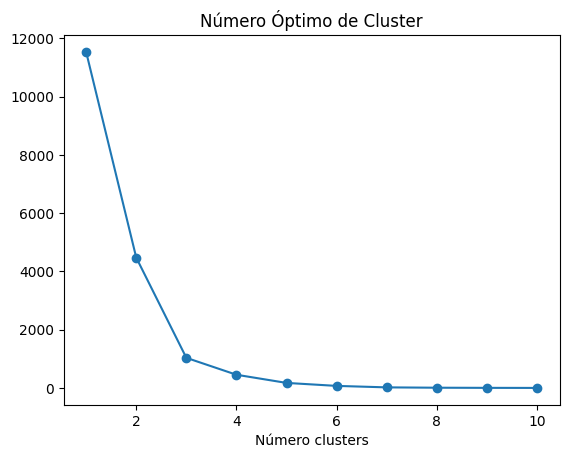

In [79]:
grafico_codo(df_norm)

In [41]:
predicted_clusters_kmeans = KMeans(n_clusters=3, random_state=1).fit_predict(X=df_norm)

c:\Users\DIFODS103\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [42]:
davies_bouldin_score_kmeans = davies_bouldin_score(df_norm, predicted_clusters_kmeans)
silhouette_score_kmeans = silhouette_score(df_norm, predicted_clusters_kmeans)
result_comp_clusters = pd.DataFrame(index=['Índice de Davies-Bouldin', 'Índice de Silhouette'])
result_comp_clusters['K-means'] = [davies_bouldin_score_kmeans, silhouette_score_kmeans]
print(result_comp_clusters)


                           K-means
Índice de Davies-Bouldin  0.364673
Índice de Silhouette      0.743349


In [43]:
df['Grupo'] = predicted_clusters_kmeans + 1

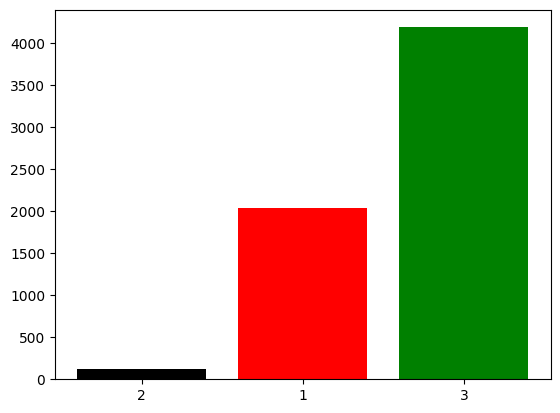

In [90]:
cluster = df.groupby('Grupo')['Grupo'].count().sort_values(ascending=True).to_frame('CONTEO').reset_index()
plt.bar(cluster['Grupo'].astype('str'),cluster['CONTEO'],color=['black', 'red', 'green'])
plt.show()

In [99]:
df[df['Grupo']==2].describe()

,ID,ID_OFERTA_FORMATIVA,ID_GRUPO,ID_CURSO,ID_PARTICIPANTE,CURID,USERID,NOTA,NOTA_MAXIMA,CONDICION,Grupo
count,1.170000e+02,117.000000,117.000000,117.000000,1.170000e+02,117.0,117.000000,117.000000,117.0,117.0,117.0
mean,3.498372e+06,237.444444,896.264957,296.769231,2.352272e+06,623.0,464421.726496,7.931624,20.0,0.0,2.0
std,1.131116e+06,2.245472,23.799954,57.307005,1.632329e+04,0.0,171860.043917,2.211750,0.0,0.0,0.0
min,2.165330e+05,235.000000,876.000000,244.000000,2.326297e+06,623.0,826.000000,0.000000,20.0,0.0,2.0
25%,3.348795e+06,235.000000,879.000000,253.000000,2.338752e+06,623.0,406137.000000,6.000000,20.0,0.0,2.0
50%,3.752370e+06,237.000000,885.000000,271.000000,2.349267e+06,623.0,511682.000000,8.000000,20.0,0.0,2.0
75%,4.362004e+06,239.000000,918.000000,337.000000,2.363758e+06,623.0,602024.000000,10.000000,20.0,0.0,2.0
max,4.425961e+06,242.000000,951.000000,433.000000,2.394685e+06,623.0,607334.000000,10.000000,20.0,0.0,2.0


In [100]:
df[df['Grupo']==1].describe()

,ID,ID_OFERTA_FORMATIVA,ID_GRUPO,ID_CURSO,ID_PARTICIPANTE,CURID,USERID,NOTA,NOTA_MAXIMA,CONDICION,Grupo
count,2.039000e+03,2039.000000,2039.000000,2039.000000,2.039000e+03,2039.0,2039.000000,2039.000000,2039.0,2039.0,2039.0
mean,3.349794e+06,237.719961,892.823933,289.105934,2.350032e+06,623.0,351398.651300,14.700343,20.0,1.0,1.0
std,1.056018e+06,2.211920,19.731413,47.527705,1.479638e+04,0.0,187009.561519,1.481305,0.0,0.0,0.0
min,2.154990e+05,235.000000,876.000000,244.000000,2.325914e+06,623.0,480.000000,12.000000,20.0,1.0,1.0
25%,2.806718e+06,236.000000,880.000000,256.000000,2.337283e+06,623.0,188538.000000,14.000000,20.0,1.0,1.0
50%,3.638482e+06,237.000000,885.000000,271.000000,2.347897e+06,623.0,359023.000000,16.000000,20.0,1.0,1.0
75%,4.297920e+06,240.000000,895.000000,301.000000,2.361766e+06,623.0,517281.500000,16.000000,20.0,1.0,1.0
max,4.425953e+06,242.000000,951.000000,433.000000,2.395194e+06,623.0,607554.000000,16.000000,20.0,1.0,1.0


In [101]:
df[df['Grupo']==3].describe()

,ID,ID_OFERTA_FORMATIVA,ID_GRUPO,ID_CURSO,ID_PARTICIPANTE,CURID,USERID,NOTA,NOTA_MAXIMA,CONDICION,Grupo
count,4.184000e+03,4184.000000,4184.000000,4184.000000,4.184000e+03,4184.0,4184.000000,4184.000000,4184.0,4184.0,4184.0
mean,3.271030e+06,237.511233,892.440966,287.510755,2.349161e+06,623.0,318347.350860,19.327438,20.0,1.0,3.0
std,1.065745e+06,2.075521,20.216953,48.524358,1.524914e+04,0.0,187839.645034,0.944986,0.0,0.0,0.0
min,2.153910e+05,235.000000,876.000000,244.000000,2.325916e+06,623.0,659.000000,18.000000,20.0,1.0,3.0
25%,2.557456e+06,236.000000,879.000000,253.000000,2.336250e+06,623.0,153847.750000,18.000000,20.0,1.0,3.0
50%,3.533880e+06,237.000000,883.000000,265.000000,2.345088e+06,623.0,301842.000000,20.000000,20.0,1.0,3.0
75%,4.253480e+06,239.000000,894.000000,298.000000,2.360958e+06,623.0,501017.500000,20.000000,20.0,1.0,3.0
max,4.426310e+06,242.000000,951.000000,433.000000,2.395298e+06,623.0,607822.000000,20.000000,20.0,1.0,3.0


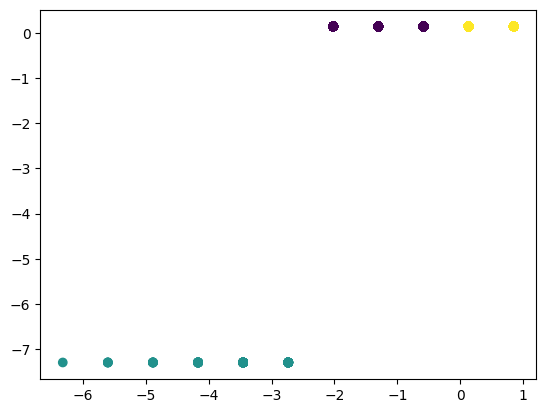

In [63]:
plt.scatter(x=df_norm[:, 0], y=df_norm[:,1],c=predicted_clusters_kmeans)
plt.show()